In [1]:
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot
import rasterio.merge
import rasterio.mask
import geopandas as gpd
import cartopy.crs as ccrs
import numpy as np
import warnings

### Start by loading in all the gauge data

In [2]:
daily_gauges = gpd.read_file("Gauge Data/Daily-Gauges-UK.shp",crs=4326)
hourly_gauges = gpd.read_file("Gauge Data/Hourly-Gauges-UK.shp",crs=4326)

#### Combine the two geo-dataframes (df)

In [3]:
gauges = hourly_gauges.append(daily_gauges)
gauges_start = set(gauges.src_id.to_list())

C:\Users\david\AppData\Local\Temp\ipykernel_7844\1150590148.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gauges = hourly_gauges.append(daily_gauges)


#### some experimenting with rasterio loading
note do use "with rasterio.open.. as src.. to help with file management r/w"

In [4]:
data = rasterio.open("DEM Data/n10e040_dem/n10e040_dem.bil")
filepath = "DEM Data/n10e040_dem/n10e040_dem.bil"
data.crs
dir(data)
data.bounds

BoundingBox(left=40.0, bottom=10.000000000000199, right=44.9999999999998, top=15.0)

#### one way is to read the file into a numpy array which you can then plot with imshow. 
this means that the file isn't opened when not necessary

Text(0, 0.5, 'Row #')

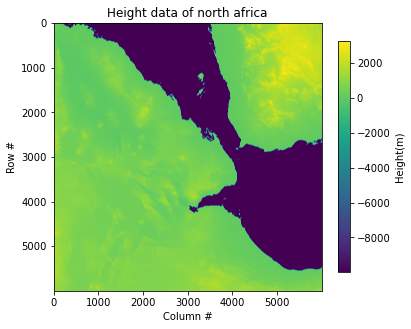

In [5]:
with rasterio.open(filepath) as src:
    subset = src.read(1)

plt.figure(figsize=(6,8.5))
plt.imshow(subset)
plt.colorbar(shrink=0.5,label="Height(m)")
plt.title(f'Height data of north africa')
plt.xlabel('Column #')
plt.ylabel('Row #')

#### more experimenting with the array method

[[-32768 -32768 -32768 ... -32768 -32768 -32768]
 [-32768 -32768 -32768 ... -32768 -32768 -32768]
 [-32768 -32768 -32768 ... -32768 -32768 -32768]
 ...
 [   217    220    224 ... -32768 -32768 -32768]
 [   216    217    219 ... -32768 -32768 -32768]
 [   213    214    216 ... -32768 -32768 -32768]]


Text(0, 0.5, 'Row #')

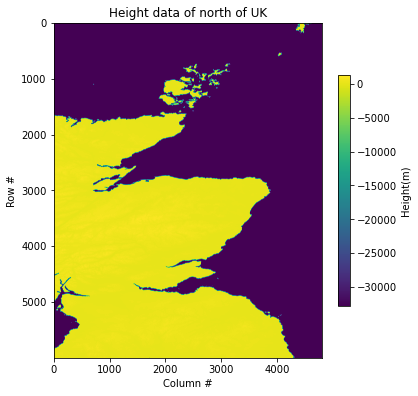

In [6]:
filepath = f"DEM data/n55w005_dem/n55w005_dem/w001001.adf"

with rasterio.open(filepath) as src:
    subset = src.read(1)

print(subset)

plt.figure(figsize=(6,8.5))
plt.imshow(subset)
plt.colorbar(shrink=0.5,label="Height(m)")
plt.title(f'Height data of north of UK')
plt.xlabel('Column #')
plt.ylabel('Row #')

#### rasterio.plot also has a fancy feature which whites out the cut our parts

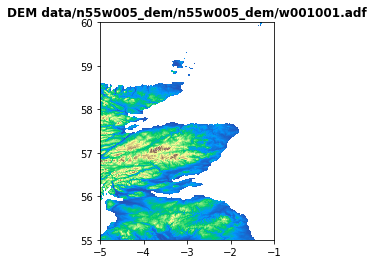

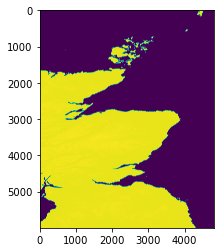

In [7]:
name = "n55w005_dem"
filepath = f"DEM data/{name}/{name}/w001001.adf"
imported_data = rasterio.open(filepath)
rasterio.plot.show(imported_data, transform=imported_data.transform, title=f"{filepath}",cmap="terrain")


with rasterio.open(filepath) as src:
    subset = src.read(1)
plt.imshow(subset)    
# plt.imsave(f"Figures/UK-{name}.jpg",subset)d

#### using the command "dir /b > filenames.txt" in cmd to generate a list of all the filenames, 
reading those into python and looping over it

In [8]:
filenames = []
with open("DEM data/filenames.txt") as fin:
    for line in fin:
        filenames.append(line.strip())
# filenames

#### selecting just the parts we want
Note: whole data set was deleted as unnecessary, full void-filled data set can be downloaded from [hydrosheds website](https://hydrosheds.org/downloads)

In [9]:
UK = filenames[68:69] + filenames[80:83] + filenames[95:97]
print(UK)

['n50e000_dem', 'n50w005_dem', 'n50w010_dem', 'n50w015_dem', 'n55w005_dem', 'n55w010_dem']


#### loads in all the data we have, takes long, dont do it. 

In [10]:
run = True
plot = False
if run:
    data = []
    for filepath in UK:
        data.append(rasterio.open(f"DEM data/{filepath}/{filepath}/w001001.adf"))
        
    for item in data:
        print(item)
    if plot:
        rasterio.plot.show(data, transform=data.transform, title=f"{filepath}")

<open DatasetReader name='DEM data/n50e000_dem/n50e000_dem/w001001.adf' mode='r'>
<open DatasetReader name='DEM data/n50w005_dem/n50w005_dem/w001001.adf' mode='r'>
<open DatasetReader name='DEM data/n50w010_dem/n50w010_dem/w001001.adf' mode='r'>
<open DatasetReader name='DEM data/n50w015_dem/n50w015_dem/w001001.adf' mode='r'>
<open DatasetReader name='DEM data/n55w005_dem/n55w005_dem/w001001.adf' mode='r'>
<open DatasetReader name='DEM data/n55w010_dem/n55w010_dem/w001001.adf' mode='r'>


#### Function to match gauge to a grid index

In [11]:
def find_raster(geometry):
    """
    Helper function to take the geometry of a gauge point and converting it to an index
    """
    # NaN and None were being difficult so a high number will sufice
    output = 99
    # Loop over each bounds
    for index, bbox in enumerate(UK_data_bounds):
        # reset local variables
        x, y = False, False
        # check x
        if bbox[0] < geometry.x and geometry.x < bbox[2]:
            x = True
        # check y
        if bbox[1] < geometry.y and geometry.y < bbox[3]:
            y = True
        # assign if both suffice 
        if x and y:
            output = index
    return output

#### Do this for the whole of the UK

In [12]:
run = True
plot = False
if run:
    UK_data = []
    UK_data_bounds = []
    for filepath in UK:
        data = rasterio.open(f"DEM data/{filepath}/{filepath}/w001001.adf")
        UK_data.append(data)
        UK_data_bounds.append(data.bounds)
        if plot:
            rasterio.plot.show(data, transform=data.transform, title=f"{filepath}")
      
    UK_total = rasterio.merge.merge(UK_data)
    if plot: 
        fig, ax = plt.subplots(1,figsize=(10,10))
        plot = rasterio.plot.show(UK_total[0].clip(-200), transform=imported_data.transform,cmap="terrain",ax=ax)
        ax.set_title("Map showing combined DEM for the UK")
        ax.set_xlabel("Latitude")
        ax.set_ylabel("Longditude")
        fig.colorbar(plot.get_images()[0], ax=ax, shrink=0.5, label="Height(m)")
#         ax.figure.savefig("Figures/whole of UK.jpg")
    
    # apply the function above
    gauges["raster_id"] = gauges.geometry.apply(find_raster)
    # Taking data we want
    not_selected_gauges = gauges.query("raster_id == 99")
    selected_gauges = gauges.query("raster_id != 99")

    #  visual representation
    if plot:
        ax = not_selected_gauges.plot(label="Not selected")
        selected_gauges.plot(ax=ax, label='Selected')
        plt.legend(bbox_to_anchor=(1, -0.05))

    # making a copy, then buffering and exporting it
    gauges_circle = selected_gauges.copy()
    
    # fixing this error broke my code
#     gauges_circle.to_crs(epsg=27700,inplace=True)

    # Changing buffersize will change the circle size and then save it to not run this forever
    gauges_circle["geometry"] = gauges_circle["geometry"].buffer(0.025)
    gauges_circle.to_file("circels with raster_id")

C:\Users\david\AppData\Local\Temp\ipykernel_7844\4014406796.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gauges_circle["geometry"] = gauges_circle["geometry"].buffer(0.025)
C:\Users\david\anaconda3\envs\python-gis\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Loading previously saved files

In [13]:
gauges_circle = gpd.read_file("circels with raster_id/circels with raster_id.shp",crs=4326)
gauges_circle.to_crs(crs=4326,inplace=True)

### comparing to see where we loose stations
gauges_found = set(gauges_circle.src_id.to_list())
print("rejects:",len(gauges_found))
ids_reject = list(gauges_start.difference(gauges_found))
for i in ids_reject:
    display(gauges.query(f" src_id == '{i}'"))

rejects: 365


,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry,raster_id
1,00009,LERWICK,lerwick,shetland,60.139,-1.185,82,1930,2020,POINT (-1.18500 60.13900),99


,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry,raster_id
172,01386,SCILLY: ST MARYS AIRPORT,scilly-st-marys-airport,isles-of-scilly,49.915,-6.296,31,1991,2020,POINT (-6.29600 49.91500),99


,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry,raster_id
2,00012,BALTASOUND NO 2,baltasound-no-2,shetland,60.748,-0.856,15,1990,2020,POINT (-0.85600 60.74800),99


Helper code to get plots

In [14]:
def get_plot(raster_id_n):
    filepath = UK[raster_id_n]
    with rasterio.open(f"DEM data/{filepath}/{filepath}/w001001.adf") as src:
         out = src.read(1)
    return out.clip(-400)

Exmaple of plotting an area

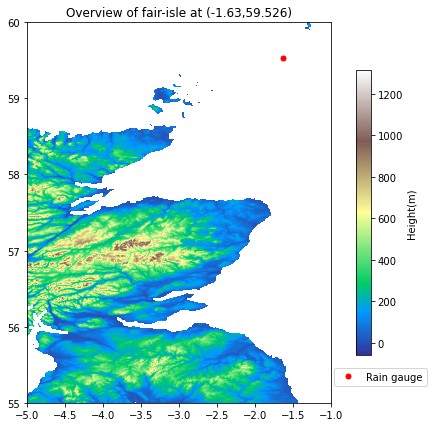

In [15]:
n = 0
raster_id_n = gauges_circle.raster_id.iloc[n] 
fig, ax = plt.subplots(1, figsize=(9, 7))
filepath = UK[raster_id_n]
with rasterio.open(f"DEM data/{filepath}/{filepath}/w001001.adf") as src:
    plot = rasterio.plot.show(src,ax=ax,cmap="terrain")
    

fig.colorbar(plot.get_images()[0], ax=ax, shrink=0.75, label="Height(m)")
df = gauges_circle.query(f"index == {n}")
plt.plot(df.station_lo.iloc[0],df.station_la.iloc[0],"ro",markersize=5,label="Rain gauge")
plt.title(f'Overview of {df.station_fi.iloc[0]} at ({df.station_lo.iloc[0]},{df.station_la.iloc[0]})')
plt.legend(bbox_to_anchor=(1.33, +0.105));

# plt.savefig(f'Figures/Overview {df.station_fi.iloc[0]}.jpg')

#### Create a mask from the circles

In [16]:
filepath = UK[raster_id_n]
with rasterio.open(f"DEM data/{filepath}/{filepath}/w001001.adf") as src:
    crop_image, crop_transform = rasterio.mask.mask(dataset=src,
                                                    shapes=gauges_circle.query(f"index == {n}").geometry,
                                                    crop=True)
    crop_meta = src.meta.copy()

#### update the meta data, using that of the mask

In [17]:
crop_meta.update({"driver": "GTiff",
                  "height": crop_image.shape[1],
                  "width": crop_image.shape[2],
                  "transform": crop_transform})

#### Write the corresponding image to file 
note the 'w' means we're writing it

In [18]:
with rasterio.open(f"Cropped Data/{UK[raster_id_n]} - {n}.adf","w",**crop_meta) as dest:
    dest.write(crop_image)

#### The plot then shows that it works

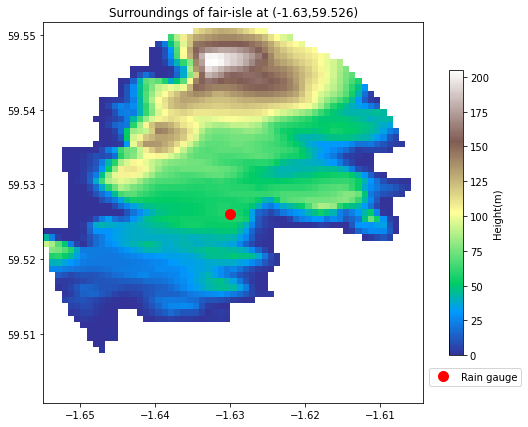

In [19]:
fig, ax = plt.subplots(1, figsize=(9, 7))
with rasterio.open(f"Cropped Data/{UK[raster_id_n]} - {n}.adf") as cropped:
    plot = rasterio.plot.show(cropped,ax=ax,cmap="terrain")    
    
fig.colorbar(plot.get_images()[0], ax=ax, shrink=0.75, label="Height(m)")
df = gauges_circle.query(f"index == {n}")
plt.plot(df.station_lo.iloc[n],df.station_la.iloc[n],"ro",markersize=10, label="Rain gauge")
plt.title(f'Surroundings of {df.station_fi.iloc[0]} at ({df.station_lo.iloc[0]},{df.station_la.iloc[0]})')
plt.legend(bbox_to_anchor=(1.27, +0.105));
# plt.savefig(f'Figures/Surroundings {df.station_fi.iloc[0]}.jpg')

#### We can combine the knowledge above into a function

In [20]:
def Crop_raster(n):
    """
    Takes index of gauges, computes mask, cuts it out by copying and adjusting meta data and savinf it 
    """
    raster_id_n = gauges_circle.raster_id.iloc[n] 
    filepath = UK[raster_id_n]
    ## open the wanted cell and load the data, creating a mask
#     print(gauges_circle.query(f"index == {n}").station_la, gauges_circle.query(f"index == {n}").station_lo)
    with rasterio.open(f"DEM data/{filepath}/{filepath}/w001001.adf") as src:
        crop_image, crop_transform = rasterio.mask.mask(dataset=src,
                                                        shapes=gauges_circle.query(f"index == {n}").geometry,
                                                        crop=True)
        crop_meta = src.meta.copy()

    ## reassign new meta data 
    crop_meta.update({"driver": "GTiff",
                      "height": crop_image.shape[1],
                      "width": crop_image.shape[2],
                      "transform": crop_transform})
    ## save with new meta data
    with rasterio.open(f"Cropped Data/{UK[raster_id_n]} - {n}.adf","w",**crop_meta) as dest:
        dest.write(crop_image)

####  loop over it for all a given range of indexes

In [21]:
def Crop_raster_all(total):
    for i in range(total):
        Crop_raster(i)
### run if previous changes have been made, mainly mask size but should be fine at 0.025 = 60x60px = 3x3km
# Crop_raster_all(365)

#### and then also plot these data, with a bunch of extra options  

In [66]:
def plot_cropped_raster(n, plot_hist=False, zoom_in=False, save=False):
    """
    Takes index of gauges DF retrieves the file and plots it.
    """
    raster_id_n = gauges_circle.raster_id.iloc[n] 
    filepath = UK[raster_id_n]
    
    # creating figures:    
    fig1, ax1 = plt.subplots(1, figsize=(10, 10));
#     fig1 = plt.figure(figsize=(12,12))
    if plot_hist:
        fig2, ax2 = plt.subplots(1, figsize=(7, 5))  
    
    with rasterio.open(f"Cropped Data/{UK[raster_id_n]} - {n}.adf") as cropped:
        plot = rasterio.plot.show(cropped, ax=ax1,cmap="terrain");
        if plot_hist:
            rasterio.plot.show_hist(cropped, ax=ax2, bins=10, 
                                    lw=0.0, stacked=False, alpha=0.9,
                                    histtype='stepfilled', title="Histogram")
    # post plotting
    fig1.colorbar(plot.get_images()[0], ax=ax1, shrink=0.75, label="Height(m)")
    df = gauges_circle.query(f"index == {n}")
    ax1.plot(df.station_lo.iloc[0], df.station_la.iloc[0], "ro", markersize=5, label="Rain gauge")
    ax1.set_title(f'Surroundings of {df.station_fi.iloc[0]} at ({df.station_lo.iloc[0]},{df.station_la.iloc[0]})',
                 pad=18);
    zoomed = ""
    if zoom_in:
        # probably a better way to dit it but this works, as only 3 decimal palces this gives an esimate of accuracy
        ax1.vlines([df.station_lo.iloc[0]+ 0.0005, df.station_lo.iloc[0]-0.0005],
                   df.station_la.iloc[0] - 0.05,df.station_la.iloc[0] + 0.05, 
                   color="red",linestyles="dashed")
        ax1.hlines([df.station_la.iloc[0]+ 0.0005, df.station_la.iloc[0]-0.0005],
                   df.station_lo.iloc[0] - 0.05,df.station_lo.iloc[0] + 0.05, 
                   color="red",label="accuracy limit",linestyles="dashed")
        ax1.set_xlim([df.station_lo.iloc[0]+ 0.005, df.station_lo.iloc[0]-0.005])
        ax1.set_ylim([df.station_la.iloc[0]+ 0.005, df.station_la.iloc[0]-0.005])
        zoomed = " zoomed-in "
        
    if plot_hist:
        ax2.legend("")
        ax2.set_xlabel("Height above MSL");
    
    ax1.legend(bbox_to_anchor=(1.25, +0.04));
    if save:
        ax1.figure.savefig(f"Plots/{n} - Surroundings of {df.station_fi.iloc[0]}{zoomed}.jpg")

#### Which in turn looks like this

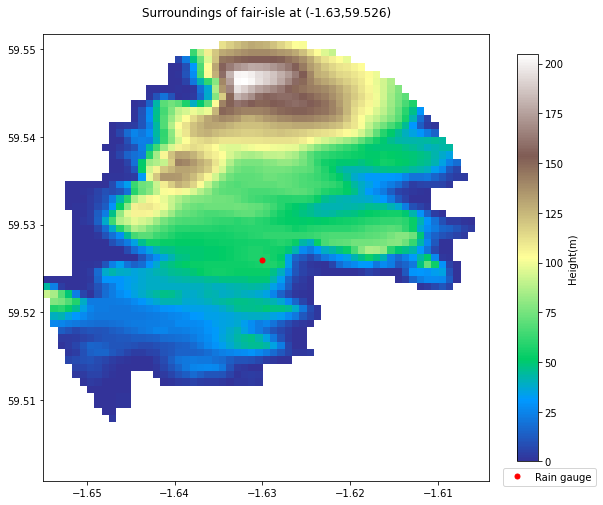

In [67]:
i = 0
plot_cropped_raster(i, False, False, False)

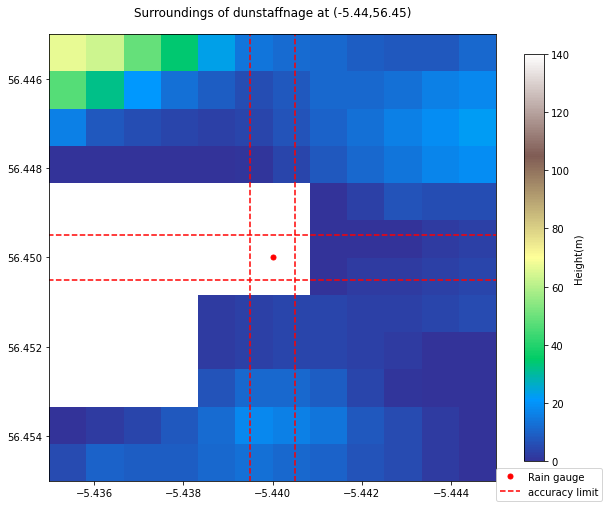

<Figure size 864x864 with 0 Axes>

In [24]:
# nice plots: #2 is on a mountain, #113 in the water & # 207 too
for i in range(113,114):
    plot_cropped_raster(i, False, True, False)

#### Just plotting it isn't enough, we want actual data about the pixel

In [25]:
def get_raster_pixel(n): 
    """
    Takes index of gauges DF clip the file, finds location and plots it
    """
    raster_id_n = gauges_circle.raster_id.iloc[n] 
    filepath = UK[raster_id_n]  
    
    df = gauges_circle.query(f"index == {n}")
    with rasterio.open(f"Cropped Data/{UK[raster_id_n]} - {n}.adf") as cropped:
        array = cropped.read(1)
        
        # own boilerplate code
        bounds = cropped.bounds
        loc_lo = int(((-bounds[0] + df.station_lo.iloc[0]) * array.shape[0]) / (-bounds[0] + bounds[2]))
        loc_la = int(((-bounds[1] + df.station_la.iloc[0]) * array.shape[1]) / (-bounds[1] + bounds[3]))
        
        # there is also a built in method... lets use that
        coords = rasterio.transform.rowcol(cropped.transform, df.station_lo.iloc[0], df.station_la.iloc[0])
        
        # should be doable with the build in sample but i couldn't get it to work
#         out = rasterio.sample.sample_gen(cropped,(df.station_lo.iloc[0],df.station_la.iloc[0]))
#         out = cropped.sample((df.station_lo.iloc[0],df.station_la.iloc[0])

    # df.station_el.iloc[0]
    return array[coords[0],coords[1]]

#### We want to do it for the whole data frame so we apply it:
Again some resetting of indices to do some work arounds 

In [26]:
run = True
if run:
    # only run to reset colums
    gauges_circle.reset_index(inplace=True)
    gauges_circle.reset_index(inplace=True)
    gauges_circle.drop(columns="index",inplace=True)
    gauges_circle["computed_height"] = gauges_circle.level_0.apply(get_raster_pixel)
    gauges_circle["difference_height"] = abs(gauges_circle.station_el - gauges_circle.computed_height)

#### Then do some data exploration

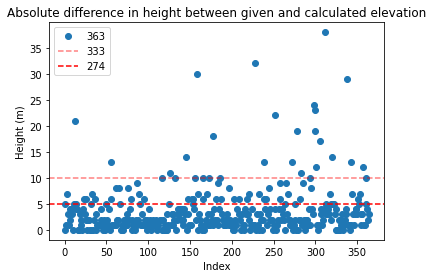

In [27]:
# Calculate some statistics
less_than_3000 = gauges_circle.query("difference_height < 3000").src_id.count()
less_than_10 = gauges_circle.query("difference_height < 10").src_id.count()
less_than_5 = gauges_circle.query("difference_height < 5").src_id.count()

# plot as points
gauges_circle.query("difference_height < 3000").difference_height.plot(style="o",label=f"{less_than_3000}")

# set labels
title = "Absolute difference in height between given and calculated elevation"
plt.title(title)
plt.xlabel("Index")
plt.ylabel("Height (m)")

# add lines
plt.axhline(10,color="red", linestyle="dashed",alpha=0.5,label=f"{less_than_10}")
plt.axhline(5,color="red", linestyle="dashed",alpha=1,label=f"{less_than_5}")
plt.legend()

# save fig
# plt.savefig(f"Figures/{title}.jpg")

#### Query the data

In [28]:
gauges_circle.query("difference_height > 3000")

,level_0,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,raster_id,geometry,computed_height,difference_height
113,113,00918,DUNSTAFFNAGE,dunstaffnage,argyll-in-strathclyde-region,56.450,-5.440,3,1980,2020,5,"POLYGON ((-5.41500 56.45000, -5.41512 56.44755...",-32768,32771
207,207,17309,CROSBY,crosby,merseyside,53.497,-3.058,9,1983,2020,1,"POLYGON ((-3.03300 53.49700, -3.03312 53.49455...",-32768,32777


In [29]:
run = False
if run:
    for i in gauges_circle.query("difference_height > 30").index:
        plot_cropped_raster(i, False, True)
        print(get_raster_pixel(i))

#### However just one point isn't enough, we want to look in different directions

In [30]:
def get_array_given_orientation(n, kind, clip=False): 
    """
    Takes index of gauges df, retrieves the file, return array of height data in the specified orientation
    """
    raster_id_n = gauges_circle.raster_id.iloc[n] 
    filepath = UK[raster_id_n]  
    
    df = gauges_circle.query(f"index == {n}")
    with rasterio.open(f"Cropped Data/{UK[raster_id_n]} - {n}.adf") as cropped:
        array = cropped.read(1)
        coords = rasterio.transform.rowcol(cropped.transform, df.station_lo.iloc[0], df.station_la.iloc[0])
    if kind == "ew":
        if clip:
            new_lst = []
            for i in array[coords[0],:]:
                if i >= 0:
                    new_lst.append(i)
                else:
                    new_lst.append(-1)
            return new_lst, coords[0]
        else:
            return array[coords[0],:], coords[0]
        
    elif kind == "ns":
        if clip:
            new_lst = []
            for i in array[:,coords[1]]:
                if i >= 0:
                    new_lst.append(i)
                else:
                    new_lst.append(-1)
            return new_lst, coords[1]

        else:
            return array[:,coords[1]], coords[1]
    elif kind == "nw-se" or kind == "ne-sw":
        if kind == "nw-se": 
            diagonal_array = np.diagonal(array)
        else:
            diagonal_array = np.fliplr(array).diagonal()
        if clip:
            new_lst = []
            for i in diagonal_array:
                if i >= 0:
                    new_lst.append(i)
                else:
                    new_lst.append(-1)
            return new_lst, coords[1]

        else:
            return diagonal_array, coords[1]

        
    else:
        ### no knid given
        print("incorrect kind")

#### Having the data, we also want to plot it:

In [31]:
def plot_gauge(n, kind="ew", clip=True, save=False):
    """
    Function which takes index of a gauge and what kind of plot wanted
    """
    # make the 'kind' readable
    label = {"ew":"East to west",
               "ns": "North to south",
            "nw-se": "North-west to south-east",
            "ne-sw": "North-east to south-west"}
    
    if kind in label:
        array, gauge_loc = get_array_given_orientation(n, kind, clip)
        # plotting
        fig, ax = plt.subplots(1, figsize=(4, 4));
        ax.plot(array, label=label[kind])
        ax.axhline(-1,color='g',label="End map", alpha=0.5)
        ax.plot(gauge_loc,get_raster_pixel(n),"ro",label="Gauge")
        ax.legend(bbox_to_anchor=(1.00, -0.14))
        ### avoid using "#" in names: latex doesnt like it
        title = f"Profile of slope around gauge n{n}"
        ax.set_title(title)
        ax.set_xlabel("Pixels")
        ax.set_ylabel("Height[m]")
        if save:
            fig.set_figheight(7)
            fig.set_figwidth(7)
            ax.legend()
            ax.figure.savefig(f'{title}{kind}.jpg')
            
    
    # recursively calls all the options & plots
    elif kind == "all":
        # plotting fancy
        kind_array = [["ew","ns"],["nw-se","ne-sw"]]
        fig, ax = plt.subplots(2,2,constrained_layout=True, figsize=(8, 8));
        title = f"Profile of slope around gauge n{n}"
        fig.suptitle(title,y=1.04,fontsize=16)
        # fig.tight_layout()
        for i in range(2):
            for j in range(2):
                kind = kind_array[i][j]
                array, gauge_loc = get_array_given_orientation(n, kind, clip)
                ax[i,j].plot(array)
                ax[i,j].axhline(-1,color='g',label="End map", alpha=0.5)
                ax[i,j].plot(gauge_loc,get_raster_pixel(n),"ro",label="Gauge")
                ax[i,j].set_title(f"Slope {label[kind]}")
                ax[1,j].set_xlabel("Pixels")
                ax[i,0].set_ylabel("Height[m]")
                ax[0,j].get_xaxis().set_visible(False)
                ax[i,1].get_yaxis().set_visible(False)

        ax[1,1].legend(bbox_to_anchor=(1.00, -0.05))
        
        if save:
            plt.savefig(f'{title} - all.jpg');   
#         for i in label:
#             plot_gauge(n,i)    
    
    else:
        print("incorrect kind")    

#### Which looks like this

<Figure size 864x864 with 0 Axes>

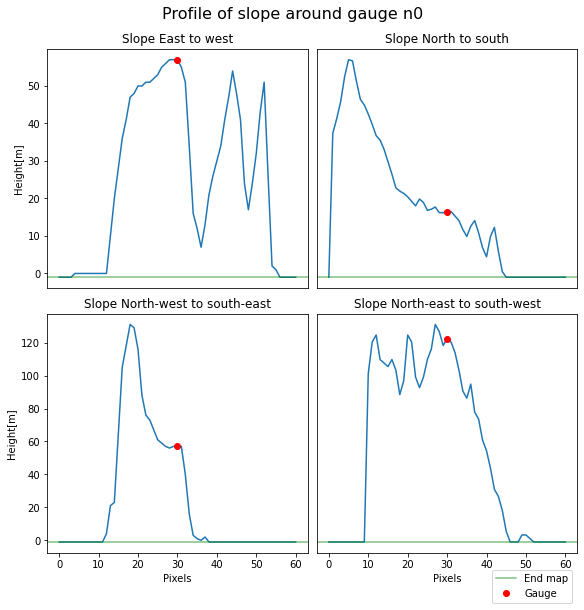

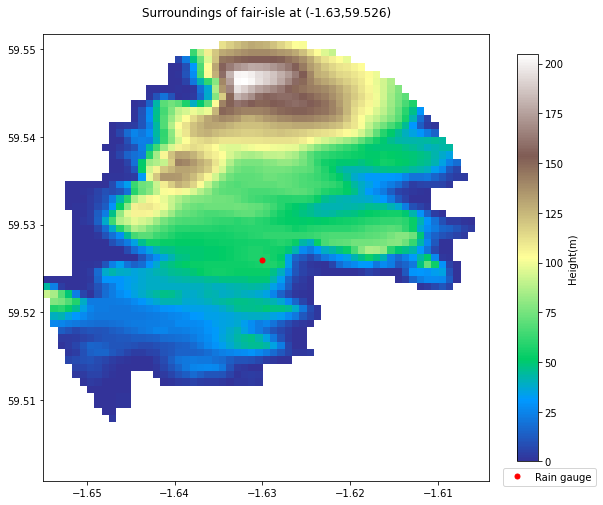

<Figure size 864x864 with 0 Axes>

In [32]:
i = 0
plot_gauge(i,"all",clip=True, save=False)
plot_cropped_raster(i, False, False, False)

#### helper function to return bounds:

In [33]:
def get_bounds(n): 
    """
    Helper function to get bounds of area
    """
    raster_id_n = gauges_circle.raster_id.iloc[n] 
    filepath = UK[raster_id_n]  
    with rasterio.open(f"Cropped Data/{UK[raster_id_n]} - {n}.adf") as cropped:
        bounds = cropped.bounds
    return bounds

#### Helper function to return the distance of beteween a pixel

In [34]:
# need resolution between each pixel:
# we know the resolution is 3 arc seconds: 
# verified here https://www.opendem.info/arc2meters.html
def distance_between_px(n):
    one_arc_second = np.cos(gauges_circle.station_la.iloc[n] * np.pi / 180) * (1852/60)
    return one_arc_second * 3
    

#### computes slope steepness:

In [35]:
def slope_steepness(n, kind="ns", n_px=1):
    """
    Given an index, direction and length to consider, calculate: 
    rise / run * 100%
    rise = 50m per contour
    run  = computed distance
    Note in order of direction, meaning a slope ns with positive implies north is higher than south, 
    this also allows us to get the direction of slope: 
    """
    # get the araay
    array, location = get_array_given_orientation(n,kind)
    
    # crop down to the length to consider
    array_cropped = array[location-n_px:location+n_px+1]
    
    # remove any cut out pixels < -3000
    array_cropped = array_cropped[array_cropped >= -3000]
    
    #average_method 
    diff = []
    for index, item in enumerate(array_cropped):
        if index < len(array_cropped) - 1:
            rise = item - array_cropped[index+1]
            diff.append(rise)
            
    return ( (sum(diff)/(len(diff)-1)) / distance_between_px(n) ) * 100

#### Runs over the previous function:

In [36]:
def slope_steepness_all_orientations(n, n_px=1): 
    """
    Function to check slope steepness in all directions
    """
    label = {"ew":"East to west",
                   "ns": "North to south",
                "nw-se": "North-west to south-east",
                "ne-sw": "North-east to south-west"}
    
    lst = []
    for orientation in label:
        lst.append(slope_steepness(n,orientation,n_px))
    return lst

#### Amount of pixels we include can vary: this takes this into account:

In [37]:
def plot_varying_n_px(lst,subplots=True,save=False):
    for i in lst:
        lst = []
        for j in range(1,30):
            n_px = j
            lst.append(slope_steepness_all_orientations(i,n_px))
        if subplots:
            fig, ax = plt.subplots(1,figsize=(4,4))
            ax.plot(lst)
            legend = ["East to west","North to south","North-west to south-east","North-east to south-west"]
            ax.legend(legend,bbox_to_anchor=(1.8,0.35))
            ax.set_xlabel("pixels taken into account")
            ax.set_ylabel("Corresponding slope percentage")
            title = f"Varying pixels for gauge n{i}"
            ax.set_title(title)
            if save:
                fig.set_figheight(7)
                fig.set_figwidth(7)
                ax.legend(legend)
                ax.figure.savefig(f'{title}.jpg',bbox_extra_artists=["legend"])
                
        else:
            plt.plot(lst)

    if not subplots:
    # set art for all 
        plt.legend(["East to west","North to south","North-west to south-east","North-east to south-west"],
                          bbox_to_anchor=(1,-0.15))
        plt.xlabel("pixels taken into account")
        plt.ylabel("Corresponding slope percentage")
        title = f"Overview of slope percentage varying pixel amounts"
        plt.title(title)      
        if save:
            plt.savefig(f"{title}.jpg")

#### Looks like this:

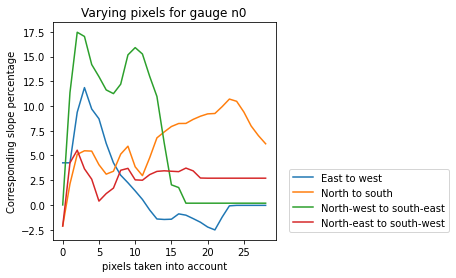

In [38]:
plot_varying_n_px(range(0,1),subplots=True,save=False)

#### The max steepness is most interesting:

In [39]:
def slope_steepness_max(n, n_px=5): 
    """
    Function to return the steepest slope of the given directions
    """
    label = {"ew":"East to west",
                   "ns": "North to south",
                "nw-se": "North-west to south-east",
                "ne-sw": "North-east to south-west"}
    lst_abs = []
    lst = []
    for orientation in label:
        percentage = slope_steepness(n,orientation,n_px)
        lst_abs.append(abs(percentage))
        lst.append(percentage)
    return round(lst[lst_abs.index(max(lst_abs))],2)

#### however also want absolute to compare it

In [40]:
def slope_steepness_max_abs(n, n_px=5): 
    """
    Function to return the steepest slope of the given directions
    """
    label = {"ew":"East to west",
                   "ns": "North to south",
                "nw-se": "North-west to south-east",
                "ne-sw": "North-east to south-west"}
    lst_abs = []
    lst = []
    for orientation in label:
        percentage = slope_steepness(n,orientation,n_px)
        lst_abs.append(abs(percentage))
        lst.append(percentage)
    return round(max(lst_abs),2)

#### And want to know in what direction it's in

In [41]:
def slope_steepness_max_direction(n, n_px=5): 
    """
    Function the direction in which the slope is steepest
    """
    label = ["ew","ns","nw-se","ne-sw"]
    lst_abs = []
    for orientation in label:
        percentage = slope_steepness(n,orientation,n_px)
        lst_abs.append(abs(percentage))
    return label[lst_abs.index(max(lst_abs))]

In [42]:
slope_steepness_max_direction(0)

'nw-se'

In [43]:
gauges_circle.sort_values("station_la",ascending=False).head(2)

,level_0,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,raster_id,geometry,computed_height,difference_height
0,0,00003,FAIR ISLE,fair-isle,shetland,59.526,-1.630,57,1974,2020,4,"POLYGON ((-1.60500 59.52600, -1.60512 59.52355...",57,0
269,269,25315,ORKNEY: LOCH OF HUNDLAND,orkney-loch-of-hundland,orkney,59.112,-3.229,28,1999,2020,4,"POLYGON ((-3.20400 59.11200, -3.20412 59.10955...",29,1


In [44]:
distance_between_px(170),distance_between_px(0)

(59.41807153589281, 46.961841443758004)

### Apply these functions dataframe wide:

In [45]:
gauges_circle["slope_steepness"] = gauges_circle.level_0.apply(slope_steepness_max)
gauges_circle["abs_slope_steepness"] = gauges_circle.level_0.apply(slope_steepness_max_abs)
gauges_circle["dir_slope_steepness"] = gauges_circle.level_0.apply(slope_steepness_max_direction)

# Explore these data:

Text(0, 0.5, 'Steepness(%)')

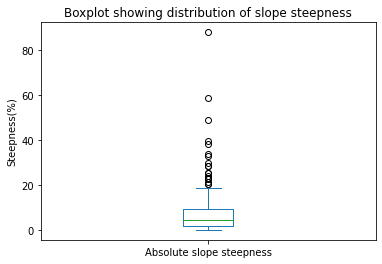

In [46]:
gauges_circle.abs_slope_steepness.plot(kind='box',label="Absolute slope steepness")
title = "Boxplot showing distribution of slope steepness"
plt.title(title)
plt.ylabel("Steepness(%)")
# plt.savefig(f"{title}.jpg")

In [47]:
IQR = gauges_circle.abs_slope_steepness.quantile(q=0.75) - gauges_circle.abs_slope_steepness.quantile(q=0.25)
Outlier_threshold = gauges_circle.abs_slope_steepness.quantile(q=0.75) + 1.5 * IQR
print(Outlier_threshold)
outliers = gauges_circle.query(f"abs_slope_steepness > {Outlier_threshold}")
print(outliers.src_id.count())
outliers_removed = gauges_circle.query(f"abs_slope_steepness < {Outlier_threshold}")

20.355
19


#### Save the data:

In [48]:
run = False
if run:    
    gauges_circle.to_csv("Slopes computed from DEM/Slopes computed from DEM.csv")
    outliers.to_csv("Sloped computed from DEM - outliers/Sloped computed from DEM - outliers.csv")

In [49]:
gauges_circle.head(1)

,level_0,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,raster_id,geometry,computed_height,difference_height,slope_steepness,abs_slope_steepness,dir_slope_steepness
0,0,00003,FAIR ISLE,fair-isle,shetland,59.526,-1.63,57,1974,2020,4,"POLYGON ((-1.60500 59.52600, -1.60512 59.52355...",57,0,14.2,14.2,nw-se


### look closer at outliers

In [50]:
extremes = gauges_circle.query("abs_slope_steepness > 30")\
                                .sort_values("abs_slope_steepness",ascending=False)\
                                .level_0.to_list()
print(extremes)
gauges_circle.query("abs_slope_steepness > 30").sort_values("abs_slope_steepness",ascending=False).head(2)

[283, 126, 278, 180, 293, 296, 284]


,level_0,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,raster_id,geometry,computed_height,difference_height,slope_steepness,abs_slope_steepness,dir_slope_steepness
283,283,00926,"BENMORE, YOUNGER BOTANIC GARDEN",benmore-younger-botanic-garden,argyll-in-strathclyde-region,56.028,-4.985,12,1961,2020,4,"POLYGON ((-4.96000 56.02800, -4.96012 56.02555...",23,11,88.04,88.04,ne-sw
126,126,01067,BLENCATHRA,blencathra,cumbria,54.620,-3.080,250,2010,2020,1,"POLYGON ((-3.05500 54.62000, -3.05512 54.61755...",261,11,58.65,58.65,ne-sw


### Easiest with plots

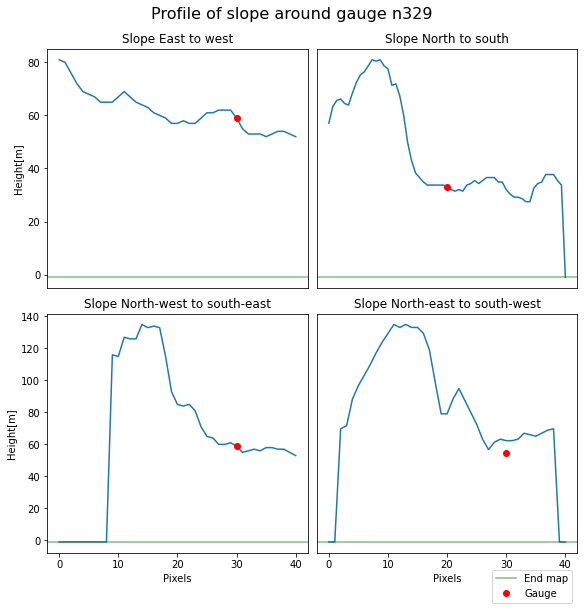

In [51]:
# 283
# 126 is just very steep

# for i in extremes:
#     plot_gauge(i,"all")
i=329
plot_gauge(i,"all")

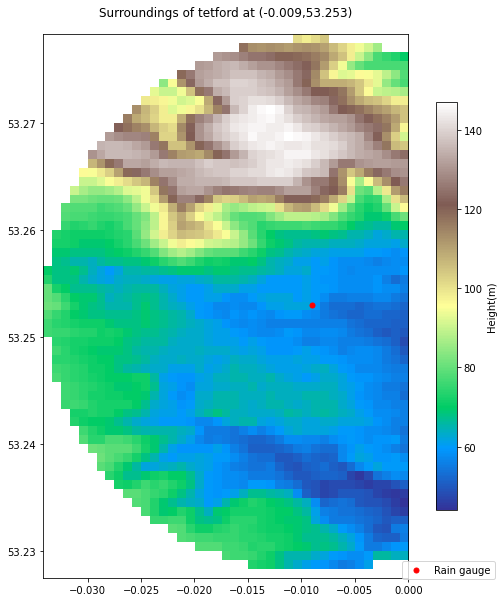

<Figure size 864x864 with 0 Axes>

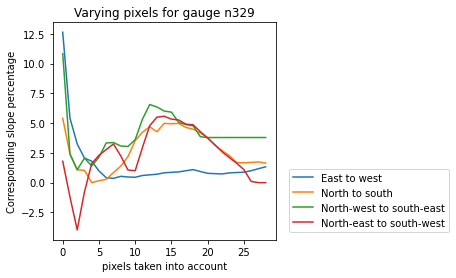

In [52]:
i = 329
plot_cropped_raster(i,False, False, False)
plot_varying_n_px([i])
slope_steepness(i,"nw-se",5)
get_array_given_orientation(i,"ns"), get_array_given_orientation(i,"ns")[0][30];

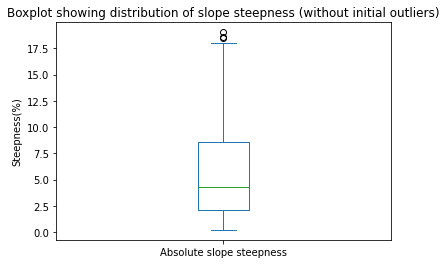

In [53]:
outliers_removed.abs_slope_steepness.plot(kind='box',label="Absolute slope steepness")
title = "Boxplot showing distribution of slope steepness (without initial outliers)"
plt.title(title)
plt.ylabel("Steepness(%)");
# plt.savefig(f"{title}.jpg")